## 📊 Forecasting Patient Uptake for Drug X: A Simulation-Based Approach
This notebook shows how to use the forecasting utility functions defined chapter 01 and stored in `utils.py` to simulate patient uptake dynamics for Drug X in a single country. 

The **objective** is to generate a funnel of possible forecasts by running several simulations, allowing for better-informed planning, expectation management, and sensitivity analysis. This approach combines epidemiological assumptions with probabilistic modeling, providing a flexible and data-driven framework to project the number of patients on treatment over time.

This simulation framework is useful for understanding a range of plausible realization patterns of the monthly patients on treatment with Drug X.

1. 📦 Setup

    Import required libraries and custom functions from `utils.py`.

In [1]:
import numpy as np
import pandas as pd

from utils import (
    simulate_monthly_eligibles,
    simulate_pts_seen_by_users,
    simulate_new_pts_treated,
    simulate_treatment_persistence,
    simulate_forecast
)

np.random.seed(123)  # Set a fixed seed for reproducibility

2. ⚙️ Define Simulation Parameters

    Set the fixed and variable parameters for the forecasting simulation.
    - Number of simulations (10 in this example to visualize the operations)

    - Annual eligible population

    - Number of months to simulate

    - Adoption and treatment assumptions (e.g.treatment probability, persistence behavior)


In [2]:
# Define the number of simulations
num_simulations = 10

# eligible population and forecast timespan
annual_eligibles = 1500 # nr of new eligible patients each year in a Country
start_date = '2025-10-01' # launch date to start the forecast
months_to_forecast = 60 # months to forecast (5 years)

# treatment probability 
intitial_user_share = 0.10
max_user_share = 0.70
months_to_peak = 36 # months to reach users at peak (3 years)
prob_to_prescribe = 0.35 # % of eligible patients that users of Drug X prescribe

# persistence on treatment
median_duration = 10
max_duration = None # patients treated until progression

3. 🔁 Run Multiple Forecast Simulations

    Run the full forecast pipeline multiple times to capture variability.

    - Create a loop over N simulations

    - Store results in a list or DataFrame for aggregation

In [3]:
# Initialize a list to store the results of each simulation
results = []

for i in range(num_simulations):
    df = simulate_monthly_eligibles(
        annual_eligibles=annual_eligibles,
        n_months=months_to_forecast,
        start_date=start_date
    ) # to be passed to eligible_df argument in the next function
    df = simulate_pts_seen_by_users(
        eligible_df=df,
        max_user_share=max_user_share,
        initial_user_share=intitial_user_share,
        months_to_peak=months_to_peak
    ) # to be passed to user_seen_df argument in the next function
    df = simulate_new_pts_treated(
        user_seen_df=df,
        mean_treatment_prob=prob_to_prescribe
    ) # to be passed to df argument in the next function
    df = simulate_forecast(
        df=df,
        median_duration_months=median_duration,
        max_duration_months=max_duration
    )
    results.append(df)

# Now you have a list of DataFrames, one for each simulation

In [4]:
results[0].head()

,Eligible_pts,Pts_seen_by_users,New_pts_treated,Pts_on_treatment
2025-10-31,132,13,5,5
2025-11-30,128,16,7,12
2025-12-31,136,9,4,14
2026-01-31,134,30,7,19
2026-02-28,115,15,7,25


4. 📊 Visualize Forecast Funnel

    Plot the distribution of patient numbers on treatment across simulations.

    - Overlay all simulation lines to show the range

    - Plot confidence bands (e.g., 10th–90th percentile)

    - Add median or mean forecast line

In [5]:
# Extract only the column of interest for the list of simulations DataFrames to be conactenated
df_sims = [
    df.filter(items=['Pts_on_treatment']) for df in results
]
df_sims = pd.concat(df_sims, axis=1)
df_sims.columns = [f'Pts_sim{i}' for i in range(num_simulations)]
df_sims.index = results[0].index  # optional, ensures consistent datetime index

df_sims.head(3)

,Pts_sim0,Pts_sim1,Pts_sim2,Pts_sim3,Pts_sim4,Pts_sim5,Pts_sim6,Pts_sim7,Pts_sim8,Pts_sim9
2025-10-31,5,5,4,7,8,9,4,5,1,2
2025-11-30,12,8,9,11,9,12,11,8,3,8
2025-12-31,14,12,11,20,8,15,14,12,10,14


In [6]:
# Compute summary statistics
percentiles = [0.05, 0.5, 0.95]
df_summary = df_sims.quantile(q=percentiles, axis=1).transpose()
df_summary.columns = [f'Pct_{int(p*100)}' for p in percentiles]
df_summary.head(3)

,Pct_5,Pct_50,Pct_95
2025-10-31,1.45,5.0,8.55
2025-11-30,5.25,9.0,12.00
2025-12-31,8.90,13.0,17.75


<Axes: title={'center': '5 Year Monthly Forecast Funnel of Patients on Drug X'}, xlabel='Time', ylabel='Nr of patients'>

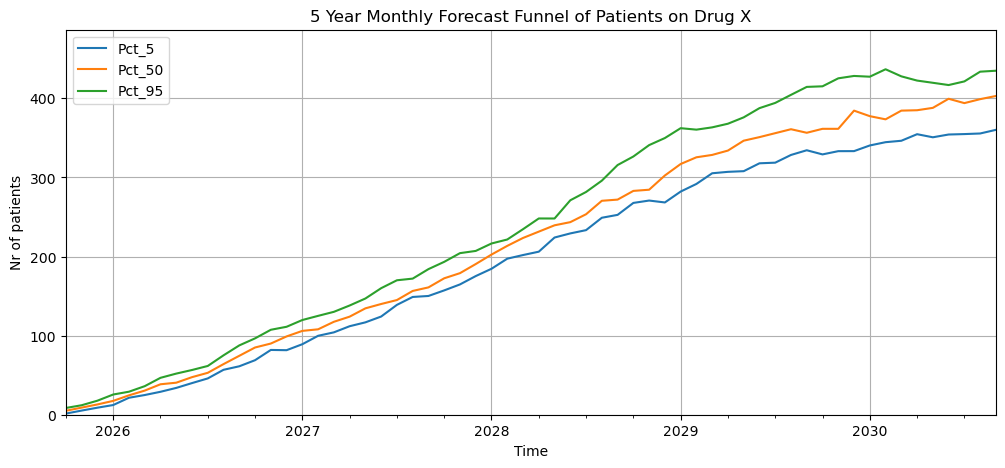

In [7]:
# Plotting
df_summary.plot(
    figsize=(12, 5),
    ylim=(0, df_summary['Pct_95'].max() + 50),
    title=f"{months_to_forecast // 12} Year Monthly Forecast Funnel of Patients on Drug X",
    ylabel='Nr of patients',
    xlabel='Time',
    grid=True
)

5. 📉 Analyze and Export Forecast Results

    🎯 Purpose: Derive key takeaways from the forecast funnel, compare expected outcomes, and optionally save the outputs for reporting or further analysis.



In [8]:
# Extract dates and values at key milestones
milestones = [12, 36, 60]  # months (1, 3, and 5 years)
milestone_summary = df_summary.iloc[[m - 1 for m in milestones]]
milestone_summary.index.name = 'Month'
display(milestone_summary)


,Pct_5,Pct_50,Pct_95
Month,,,
2026-09-30,61.25,74.5,87.65
2028-09-30,252.70,272.0,315.70
2030-09-30,360.20,403.0,434.95


In [9]:
for month in milestones:
    patients = df_summary.loc[df_summary.index[month - 1], 'Pct_50']
    print(f"Estimated median patients on treatment at month {month}: {patients:.0f}")


Estimated median patients on treatment at month 12: 74
Estimated median patients on treatment at month 36: 272
Estimated median patients on treatment at month 60: 403


Export Results:

In [10]:
# Specify the Excel file path
excel_file_path = "../data/forecast_summary.xlsx"
csv_file_path = '../data/forecast_simulations.csv'

# Save the simulation outputs to CSV
df_sims.to_csv(csv_file_path, index=True) # Set index=True to include the index column

# Save the summary outputs to excel
df_summary.to_excel(excel_file_path, index=True)  # Set index=True to include the index column

print(f"Forecast Summary saved in {excel_file_path}")

Forecast Summary saved in ../data/forecast_summary.xlsx


### Summary
This notebook showed how to simulate and forecast the number of patients on treatment with **Drug X** over time using a modular and flexible modeling approach.

Starting from the definition of an eligible patient population, I simulated their journey through multiple stages — being seen by users, starting treatment, and persisting on therapy — to produce a forecast funnel that captures the variability and uncertainty in real-world dynamics.

The workflow consists of five steps:

1. **Set Forecast Parameters.**
    Define inputs such as eligible population size, launch date, user adoption, treatment probability, and persistence duration.

2. **Run Simulations.**
    Generate multiple forecasts to reflect uncertainty using random processes for patient behavior and treatment dynamics.

3. **Aggregate Results.**
    Consolidate the outcomes across simulations into a single structure for analysis.

4. **Summarize Forecast Funnel.**
    Calculate and visualize percentiles (e.g., 5th, 50th, 95th) to communicate expected range and confidence.

5. **Analyze or Export.**
    Extract key metrics for reporting, and optionally save outputs for future use.

This structure provides a foundation for country-level forecasting and can be extended to test alternative scenarios, assumptions, or be applied across multiple markets.



